In [39]:
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.optimizers import Adadelta,Adam,RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

Dataset comes from kaggle: https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [40]:
data = pd.read_csv("spam.csv", encoding = 'latin-1',usecols=[0,1])
data.columns=['target','text']
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [41]:
len(data['text'])

5572

Would lemmatization be better than stemming? Let's look at both.

In [42]:
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

Here we'll build a function for the message preprocessing - one using a lemmatizer, one using a stemmer.

In [43]:
def cleanStem(message):
    
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word.lower()) for word in message.split() if word.lower() not in stopwords.words("english")]
    
    return " ".join(words)
def cleanLemma(message):
    
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [lemmatizer.lemmatize(word.lower()) for word in message.split() if word.lower() not in stopwords.words("english")]
    
    return " ".join(words)

Here we'll see what the differences were for a typical spam message.

In [44]:
print("Original: "+data['text'][2])
print("Stemmed: "+cleanStem(data['text'][2]))
print("Lemmatized: "+cleanLemma(data['text'][2]))

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Stemmed: free entri 2 wkli comp win fa cup final tkts 21st may 2005 text fa 87121 receiv entri questionstd txt ratetc appli 08452810075over18
Lemmatized: free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s


Honestly the differences weren't significant. We'll go with a lemmatizer because I personally believe they allow greater comparison across messages, giving greater depth to the data.

In [45]:
data['text'] = data['text'].apply(cleanLemma)

Here's an example of the cleaned text.

In [8]:
data['text'][0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

Next we'll convert our text into vectors using tfidf.

In [9]:
vec = TfidfVectorizer(encoding = 'latin-1', strip_accents = 'unicode', stop_words = 'english')
features = vec.fit_transform(data['text'])
print(features.shape)

(5572, 8668)


Now we can one hot encode the target variable. We'll let spam messages be 1, with ham messages being 0.

In [46]:
def encode(target):
    if target == 'spam':
        return 1
    else:
        return 0
data['target'] = data['target'].apply(encode)

In [47]:
data.head(n=3)

,target,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...


Split data into test and train. The problem with these heavily skewed classifier problems is that there aren;t that many spam messages.

In [48]:
print(str(round(len(data[data['target']==1])/len(data['target'])*100,2))+"% of messages in dataset are spam.")

13.41% of messages in dataset are spam.


In [49]:
xtrain, xtest, ytrain, ytest = train_test_split(data['text'], data['target'], stratify = data['target'], test_size = 0.15)

In [36]:
xtrain

4444                              2 celebrate båõday else
2748    send number give reply tomorrow morning said l...
4641    ripped get mobile content wwwclubmobycom call ...
372                       im going bath msg next ltgt min
4832    new mobile 2004 must go txt nokia 89545 collec...
                              ...                        
3670                             yup thk u oso boring wat
2522    dunno lei might b eatin wif frens ì wan eat wa...
3518                               hanging brother family
2491                            greeting consider excused
2929                                wats dear sleeping ah
Name: text, Length: 4736, dtype: object

In [14]:
batch_size = 128
nb_epoch = 5

In [32]:
model = Sequential()
model.add(Dense(1000,input_shape= (8668,), kernel_regularizer=l2(0.01)))
model.add(Dense(512, kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1,kernel_regularizer=l2(0.01), activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              8669000   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 9,214,409
Trainable params: 9,214,409
Non-trainable params: 0
_________________________________________________________________


In [50]:
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

xtrain = sequence.pad_sequences(xtrain, maxlen=maxlen)
xtest = sequence.pad_sequences(xtest, maxlen=maxlen)

model = Sequential()
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(xtrain, ytrain,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(xtest, ytest))

ValueError: invalid literal for int() with base 10: 'drive read need write'

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model.fit(xtrain, ytrain,
                nb_epoch=nb_epoch, batch_size=batch_size,
                verbose=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
4736/4736 [==============================] - 10s 2ms/step - loss: 7.1644 - accuracy: 0.8609
Epoch 2/5
4736/4736 [==============================] - 10s 2ms/step - loss: 0.6476 - accuracy: 0.8659
Epoch 3/5
4736/4736 [==============================] - 11s 2ms/step - loss: 0.3271 - accuracy: 0.8659
Epoch 4/5
4736/4736 [==============================] - 11s 2ms/step - loss: 0.2908 - accuracy: 0.9457
Epoch 5/5
4736/4736 [==============================] - 11s 2ms/step - loss: 0.2722 - accuracy: 0.9582


In [18]:
score = model.evaluate(xtest, ytest,
                       batch_size=batch_size, verbose=1)

836/836 [==============================] - 1s 758us/step


In [19]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.2761098196346794
Test accuracy: 0.9557416439056396


In [20]:
# Predict the values from the validation dataset
ypred = model.predict(xtest)
# Convert predictions classes to one hot vectors 
ypred_classes = np.argmax(ypred,axis = 1) 

In [21]:
confusion_mtx = confusion_matrix(ytest, ypred_classes) 

In [22]:
print("There were this many predicted spam messages: "+str(len(ypred_classes[ypred_classes==1])))
print("There were this many actual spam messages: "+str(len(ytest[ytest==1])))

There were this many predicted spam messages: 0
There were this many actual spam messages: 112


In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

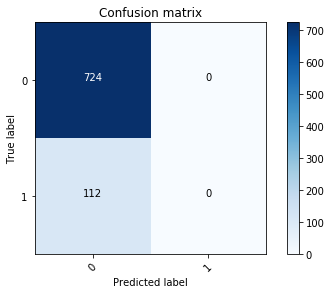

In [24]:
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [25]:
ypred

array([[2.29717791e-02],
       [2.25889385e-02],
       [6.44786060e-02],
       [2.84631550e-02],
       [1.30534172e-02],
       [8.63057375e-03],
       [2.21626163e-02],
       [3.43456566e-02],
       [5.08910179e-01],
       [7.38096833e-02],
       [3.45754325e-01],
       [3.04304063e-02],
       [5.77776730e-02],
       [2.72734761e-02],
       [2.51345932e-02],
       [5.08910179e-01],
       [6.38236403e-02],
       [5.69280684e-02],
       [1.33495033e-02],
       [1.02963537e-01],
       [7.33647645e-02],
       [5.08910179e-01],
       [4.46351171e-02],
       [6.87721372e-02],
       [2.02251077e-02],
       [5.08910179e-01],
       [1.46764517e-02],
       [3.55496407e-02],
       [6.97367787e-02],
       [6.44907057e-02],
       [2.41477489e-02],
       [2.24218071e-02],
       [4.00521755e-02],
       [3.13491821e-02],
       [2.30231285e-02],
       [3.00446451e-02],
       [8.87781382e-03],
       [4.11925912e-02],
       [3.99146020e-01],
       [4.68194485e-02],


In [26]:
xtrain[:, 1]

<4736x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>